In [1]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from pyscf import gto, scf
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# Build network - number of electrons, 1d functions, spin interation/feature

# Initialize functions considering nuclear and electronic info...
# Loss function for electronic structure, i.e. Schrodinger Equation
# VMC/MCMC for sampling functions and updating parameters through loss function evaluation/expectation value
# Update positions and functions

In [2]:
# Input for nuclear positions. From FermiNet configs
BOND_LENGTHS = {
    'BeH': 1.348263,
    'CN': 1.134797,
    'ClF': 1.659091,
    'F2': 1.420604,
    'H2': 0.737164,
    'HCl': 1.2799799,
    'Li2': 2.77306,
    'LiH': 1.639999,
    'N2': 1.129978,
    'NH': 1.039428,
    'CO': 1.150338
}

In [3]:
# # Create molecule
mol = gto.M(
   atom = 'H 0 0 0;', # H 0 0 0.737164;',
   basis = 'sto-3g',
   spin = 1
)
# Total number of electrons
total_electrons = mol.nelectron

# Correct way to get atom symbols
nuclear_charges = mol.atom_charges()

def parse_atom_string(mol):
   # Split the atom string by semicolons
   atom_sections = mol.atom.split(';')
   
   # For each section, get the first alphabetic character(s)
   atoms = []
   for section in atom_sections:
       # Skip empty sections
       if section.strip():
           # Get first part of section (before numbers)
           atom_symbol = section.strip().split()[0]
           # Only add if it's an atomic symbol (letters only)
           if atom_symbol.isalpha():
               atoms.append(atom_symbol)
   
   return atoms

def create_unique_atom_dict(atoms, nuclear_charges):
    # Count occurrences of each atom
    atom_count = Counter()
    unique_atoms = []
    
    # Create unique keys for repeated atoms
    for atom in atoms:
        atom_count[atom] += 1
        if atom_count[atom] == 1:
            unique_atoms.append(atom)
        else:
            unique_atoms.append(f"{atom}_{atom_count[atom]}")
    
    # Create dictionary with unique keys
    return dict(zip(unique_atoms, nuclear_charges))

atoms = parse_atom_string(mol)
nuclear_charges = mol.atom_charges().tolist()

atom_charges = {f"{atom}_{i+1}" if atoms.count(atom) > 1 else atom: charge 
                for i, (atom, charge) in enumerate(zip(atoms, nuclear_charges))}

print(atom_charges) 

# Spin number info - fix spins by Hund's Rule, spin not present in Born-Oppenheimer Approx. 
# Learnable spins not needed/can be hard coded
# spin_up = mol.nelectron // 2  # Number of spin-up electrons
# spin_down = mol.nelectron // 2   # Number of spin-down electrons


{'H': 1}


In [4]:
# # Total number of electrons
# NUM_ELECTRONS = total_electrons
# INPUT_DIM = NUM_ELECTRONS * 3
# OUTPUT_DIM = NUM_ELECTRONS


# Create MultKAN model with specified widths
# Create the initial MultKAN model
#model = KAN(width=[1,1], grid=5, k=3, seed=0)
model = MultKAN(width=[3,[0,1]], grid=5, k=4, seed=42, mult_arity=3, base_fun='identity')

checkpoint directory created: ./model
saving model version 0.0


In [5]:
# Create dataset
f_init = lambda x:  (x[:,[0]]) * torch.exp((-1/3) * x[:,[0]]) * torch.cos(x[:,[1]] * torch.pi / 20)
#torch.rand(x[:, 0].size(0))
dataset = create_dataset(f_init, n_var=3, ranges=[0,20], train_num=10000, test_num=5000)
print("Dataset shapes:", dataset['train_input'].shape, dataset['train_label'].shape)

Dataset shapes: torch.Size([10000, 3]) torch.Size([10000, 1])


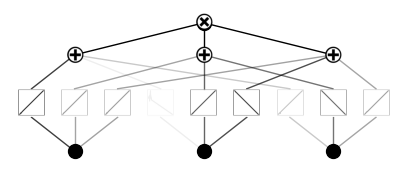

In [6]:
model(dataset['train_input'])
model.plot(beta=1)

saving model version 0.1
saving model version 0.2
saving model version 0.3


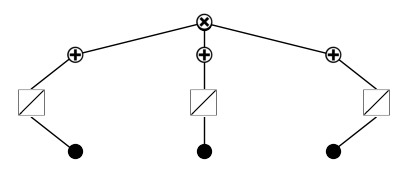

In [7]:
def chain_str(num_electrons: int) -> str:
    functions_1d = num_electrons * 3
    chains = []
    for function_idx in range(functions_1d):
        chains.append(f'{[function_idx]}->{[function_idx]}')

    return chains

chains = chain_str(1)

# Set up all connections
for chain in chains:
    model.module(0, chain)

model.plot(beta=10)

In [8]:
model.fit(dataset, steps=50)

| train_loss: 7.11e-03 | test_loss: 7.16e-03 | reg: 9.70e-01 | : 100%|█| 50/50 [00:12<00:00,  3.99it

saving model version 0.4


{'train_loss': [array(0.3539985, dtype=float32),
  array(0.09143641, dtype=float32),
  array(0.07413452, dtype=float32),
  array(0.06634201, dtype=float32),
  array(0.06003656, dtype=float32),
  array(0.05169053, dtype=float32),
  array(0.04775751, dtype=float32),
  array(0.04269955, dtype=float32),
  array(0.03817543, dtype=float32),
  array(0.02802972, dtype=float32),
  array(0.02629399, dtype=float32),
  array(0.02547522, dtype=float32),
  array(0.02483137, dtype=float32),
  array(0.02394453, dtype=float32),
  array(0.02331777, dtype=float32),
  array(0.02198304, dtype=float32),
  array(0.02174709, dtype=float32),
  array(0.02170935, dtype=float32),
  array(0.02169572, dtype=float32),
  array(0.0216602, dtype=float32),
  array(0.02163428, dtype=float32),
  array(0.02161749, dtype=float32),
  array(0.02159657, dtype=float32),
  array(0.02156287, dtype=float32),
  array(0.0215512, dtype=float32),
  array(0.02152519, dtype=float32),
  array(0.02151388, dtype=float32),
  array(0.0214795

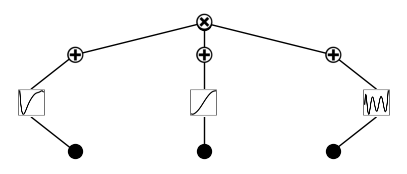

In [9]:
model.plot()

In [10]:
# Put into training loop with train_label update and VMC

grids = np.array([3,10,20])

train_losses = []
test_losses = []
steps = 25

for i in range(grids.shape[0]):
        model = model.refine(grids[i])
        results = model.fit(dataset, opt="LBFGS", steps=steps)
        train_losses += results['train_loss']
        test_losses += results['test_loss']

saving model version 0.5


| train_loss: 5.01e-03 | test_loss: 5.12e-03 | reg: 9.49e-01 | : 100%|█| 25/25 [00:05<00:00,  4.87it


saving model version 0.6
saving model version 0.7


| train_loss: 1.39e-03 | test_loss: 1.41e-03 | reg: 9.32e-01 | : 100%|█| 25/25 [00:06<00:00,  3.60it


saving model version 0.8
saving model version 0.9


| train_loss: 4.04e-04 | test_loss: 4.35e-04 | reg: 9.26e-01 | : 100%|█| 25/25 [00:10<00:00,  2.37it

saving model version 0.10


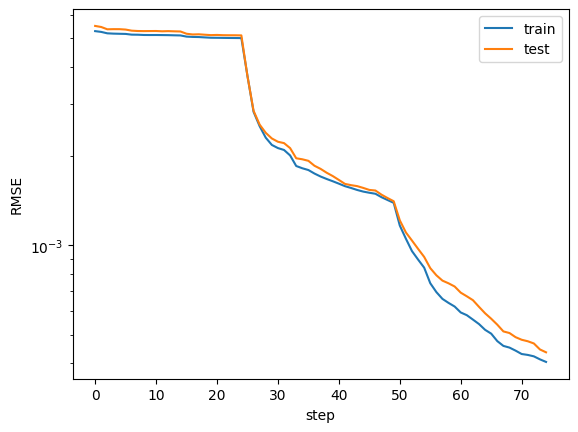

In [11]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

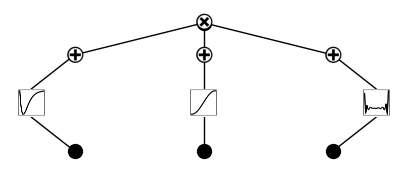

In [12]:
model.plot()

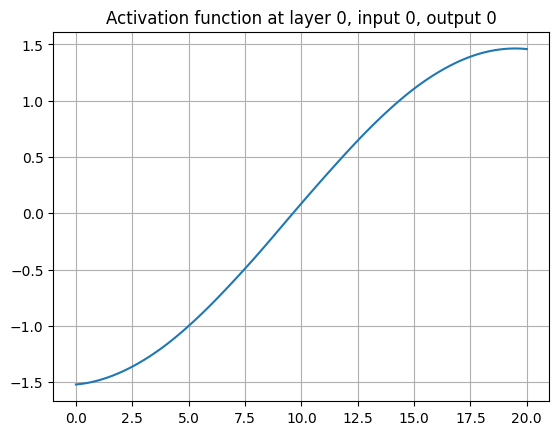

In [13]:
def evaluate_activation_spline(model, layer, in_idx, out_idx, x_points):
    """
    Evaluate a specific activation spline at given points.
    
    Args:
        model: MultKAN model
        layer: int, layer index
        in_idx: int, input neuron index
        out_idx: int, output neuron index
        x_points: torch.tensor, points at which to evaluate
        
    Returns:
        y_points: torch.tensor, evaluated values
    """
    def evaluate_bspline_basis(x, i, k, knots):
        """Evaluate a B-spline basis function using Cox-de Boor recursion."""
        if k == 0:
            return torch.where((knots[i] <= x) & (x < knots[i+1]), 
                             torch.ones_like(x), 
                             torch.zeros_like(x))
        
        denom1 = knots[i+k] - knots[i]
        term1 = torch.where(denom1 != 0, 
                          (x - knots[i]) / denom1 * evaluate_bspline_basis(x, i, k-1, knots),
                          torch.zeros_like(x))
        
        denom2 = knots[i+k+1] - knots[i+1]
        term2 = torch.where(denom2 != 0,
                          (knots[i+k+1] - x) / denom2 * evaluate_bspline_basis(x, i+1, k-1, knots),
                          torch.zeros_like(x))
        
        return term1 + term2

    def evaluate_spline(x, coeffs, knots, k):
        """Evaluate B-spline at points x using given coefficients."""
        result = torch.zeros_like(x)
        for i in range(len(coeffs)):
            basis = evaluate_bspline_basis(x, i, k-1, knots)
            result += coeffs[i] * basis
        return result

    # Get the layer's activation function
    act_layer = model.act_fun[layer]
    
    # Get the coefficients and parameters for this specific connection
    coeffs = act_layer.coef[in_idx, out_idx]
    grid = act_layer.grid[in_idx]
    k = act_layer.k
    
    # Create evaluation points
    x = x_points.reshape(-1, 1)  # Shape: [n_points, 1]
    
    # Get base function contribution
    base_out = act_layer.base_fun(x) * act_layer.scale_base[in_idx, out_idx]
    
    # Get spline contribution
    spline_out = evaluate_spline(x, coeffs, grid, k) * act_layer.scale_sp[in_idx, out_idx]
    
    # Apply mask if exists
    if hasattr(act_layer, 'mask'):
        mask = act_layer.mask[in_idx, out_idx]
        spline_out = spline_out * mask
    
    return base_out + spline_out

# Example usage:
x_eval = torch.linspace(0, 20, 100)
y_eval = evaluate_activation_spline(model, layer=0, in_idx=1, out_idx=1, x_points=x_eval)
plt.plot(x_eval.numpy(), y_eval.detach().numpy())
plt.grid(True)
plt.title(f'Activation function at layer 0, input 0, output 0')
plt.show()

(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'Activation Function\nLayer 0, Input 0, Output 0'}, xlabel='Input', ylabel='Output'>,
  <Axes: title={'center': 'Cumulative Integral'}, xlabel='Input', ylabel='Integral'>))

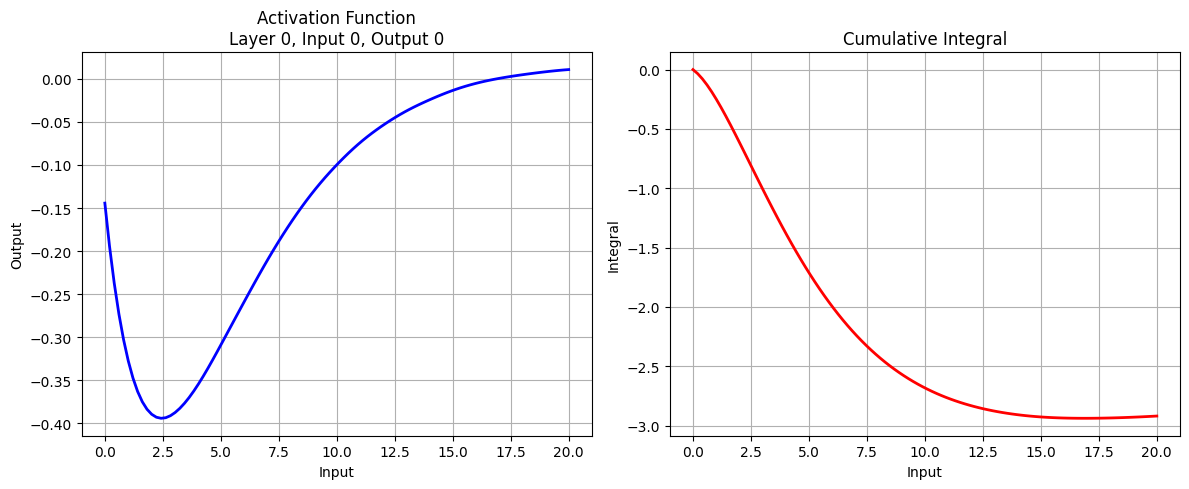

In [14]:
def evaluate_activation_spline(model, layer, in_idx, out_idx, x_points, integrate=False):
    """
    Evaluate a specific activation spline at given points and optionally integrate it.
    
    Args:
        model: MultKAN model
        layer: int, layer index
        in_idx: int, input neuron index
        out_idx: int, output neuron index
        x_points: torch.tensor, points at which to evaluate
        integrate: bool, if True returns both function values and cumulative integral
        
    Returns:
        if integrate=False:
            y_points: torch.tensor, evaluated values
        if integrate=True:
            (y_points, integral_points): tuple of torch.tensors
    """
    def evaluate_bspline_basis(x, i, k, knots):
        """Evaluate a B-spline basis function using Cox-de Boor recursion."""
        if k == 0:
            return torch.where((knots[i] <= x) & (x < knots[i+1]), 
                             torch.ones_like(x), 
                             torch.zeros_like(x))
        
        denom1 = knots[i+k] - knots[i]
        term1 = torch.where(denom1 != 0, 
                          (x - knots[i]) / denom1 * evaluate_bspline_basis(x, i, k-1, knots),
                          torch.zeros_like(x))
        
        denom2 = knots[i+k+1] - knots[i+1]
        term2 = torch.where(denom2 != 0,
                          (knots[i+k+1] - x) / denom2 * evaluate_bspline_basis(x, i+1, k-1, knots),
                          torch.zeros_like(x))
        
        return term1 + term2

    def evaluate_spline(x, coeffs, knots, k):
        """Evaluate B-spline at points x using given coefficients."""
        result = torch.zeros_like(x)
        for i in range(len(coeffs)):
            basis = evaluate_bspline_basis(x, i, k-1, knots)
            result += coeffs[i] * basis
        return result

    def integrate_numerically(x, y):
        """
        Compute cumulative integral using trapezoidal rule.
        Returns the cumulative integral at each point in x.
        """
        dx = x[1:] - x[:-1]
        y_avg = (y[1:] + y[:-1]) / 2
        increments = dx * y_avg
        integral = torch.zeros_like(y)
        integral[1:] = torch.cumsum(increments, dim=0)
        return integral

    # Get the layer's activation function
    act_layer = model.act_fun[layer]
    
    # Get the coefficients and parameters for this specific connection
    coeffs = act_layer.coef[in_idx, out_idx]
    grid = act_layer.grid[in_idx]
    k = act_layer.k
    
    # Create evaluation points
    x = x_points.reshape(-1, 1)
    
    # Get base function contribution
    base_out = act_layer.base_fun(x) * act_layer.scale_base[in_idx, out_idx]
    
    # Get spline contribution
    spline_out = evaluate_spline(x, coeffs, grid, k) * act_layer.scale_sp[in_idx, out_idx]
    
    # Apply mask if exists
    if hasattr(act_layer, 'mask'):
        mask = act_layer.mask[in_idx, out_idx]
        spline_out = spline_out * mask
    
    y_points = base_out + spline_out

    if integrate:
        integral = integrate_numerically(x.squeeze(), y_points.squeeze())
        return y_points, integral
    
    return y_points

# Example usage:
def plot_spline_with_integral(model, layer, in_idx, out_idx, x_range=(0, 20), n_points=100):
    """
    Plot both the activation function and its integral.
    """
    x_eval = torch.linspace(x_range[0], x_range[1], n_points)
    y_eval, integral = evaluate_activation_spline(
        model, layer, in_idx, out_idx, x_eval, integrate=True
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot activation function
    ax1.plot(x_eval.numpy(), y_eval.detach().numpy(), 'b-', linewidth=2)
    ax1.grid(True)
    ax1.set_title(f'Activation Function\nLayer {layer}, Input {in_idx}, Output {out_idx}')
    ax1.set_xlabel('Input')
    ax1.set_ylabel('Output')
    
    # Plot integral
    ax2.plot(x_eval.numpy(), integral.detach().numpy(), 'r-', linewidth=2)
    ax2.grid(True)
    ax2.set_title('Cumulative Integral')
    ax2.set_xlabel('Input')
    ax2.set_ylabel('Integral')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Usage:
plot_spline_with_integral(model, layer=0, in_idx=0, out_idx=0)

(<Figure size 1800x500 with 3 Axes>,
 (<Axes: title={'center': 'Individual Activation Functions'}, xlabel='Input', ylabel='Output'>,
  <Axes: title={'center': 'Multiplied Function'}, xlabel='Input', ylabel='Output'>,
  <Axes: title={'center': 'Cumulative Integral'}, xlabel='Input', ylabel='Integral'>))

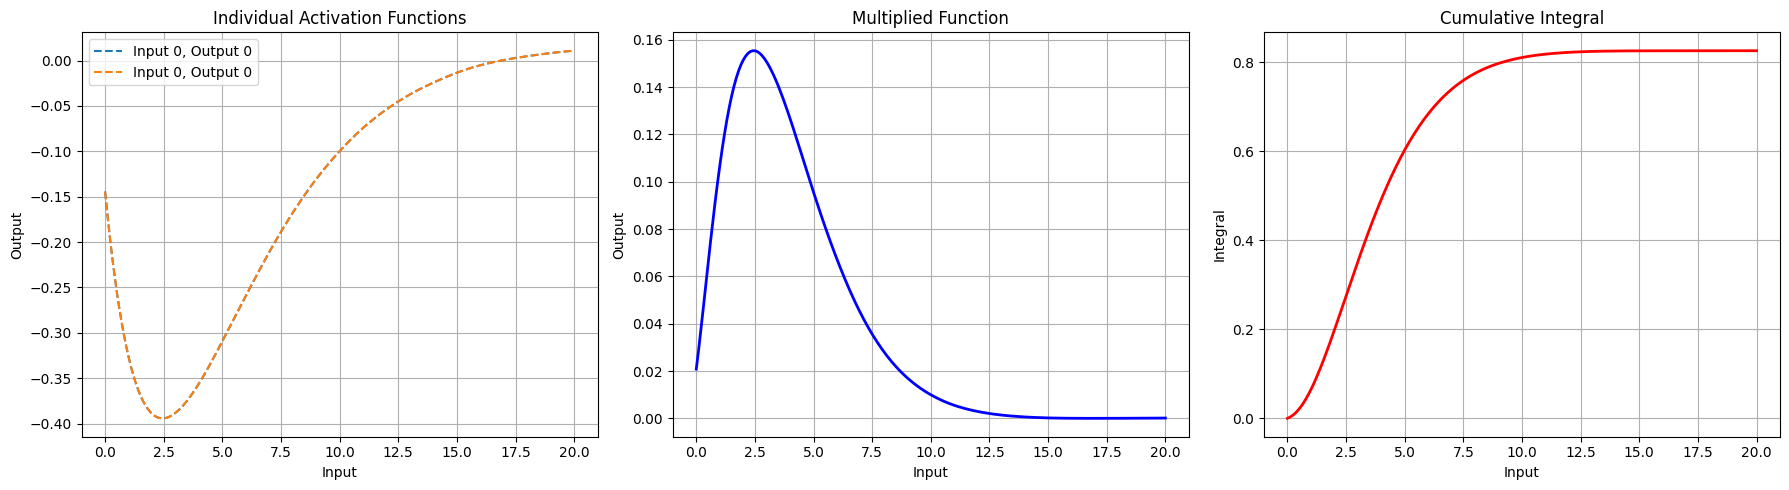

In [15]:
def evaluate_activation_splines(model, layer, index_pairs, x_points, operation='multiply', integrate=False):
    """
    Evaluate multiple activation splines and combine them with improved smoothness.
    
    Args:
        model: MultKAN model
        layer: int, layer index
        index_pairs: list of tuples [(in_idx1, out_idx1), (in_idx2, out_idx2), ...]
        x_points: torch.tensor, points at which to evaluate
        operation: str, 'multiply' or 'add'
        integrate: bool, if True returns both function values and cumulative integral
    """
    def evaluate_bspline_basis(x, i, k, knots):
        """
        Evaluate a B-spline basis function using improved Cox-de Boor recursion.
        """
        if k == 0:
            # Handle boundary conditions properly
            left_condition = (knots[i] <= x)
            right_condition = (x < knots[i+1])
            right_boundary = (x == knots[i+1]) & (i == len(knots)-2)
            return torch.where(left_condition & (right_condition | right_boundary),
                             torch.ones_like(x),
                             torch.zeros_like(x))
        
        # Compute terms with better numerical stability
        denom1 = knots[i+k] - knots[i]
        left_coef = torch.where(denom1 > 1e-10,
                              (x - knots[i]) / denom1,
                              torch.zeros_like(x))
        
        denom2 = knots[i+k+1] - knots[i+1]
        right_coef = torch.where(denom2 > 1e-10,
                               (knots[i+k+1] - x) / denom2,
                               torch.zeros_like(x))
        
        # Recursive evaluation
        term1 = left_coef * evaluate_bspline_basis(x, i, k-1, knots)
        term2 = right_coef * evaluate_bspline_basis(x, i+1, k-1, knots)
        
        return term1 + term2

    def evaluate_spline(x, coeffs, knots, k):
        """
        Evaluate B-spline at points x using given coefficients.
        """
        result = torch.zeros_like(x)
        
        # Evaluate basis functions and multiply by coefficients
        for i in range(len(coeffs)):
            basis = evaluate_bspline_basis(x, i, k-1, knots)
            result += coeffs[i] * basis
        
        return result

    def integrate_numerically(x, y):
        """Compute cumulative integral using trapezoidal rule."""
        dx = x[1:] - x[:-1]
        y_avg = (y[1:] + y[:-1]) / 2
        increments = dx * y_avg
        integral = torch.zeros_like(y)
        integral[1:] = torch.cumsum(increments, dim=0)
        return integral

    # Get the layer's activation function
    act_layer = model.act_fun[layer]
    
    # Create evaluation points
    x = x_points.reshape(-1, 1)
    
    # Evaluate each function
    y_values = []
    for in_idx, out_idx in index_pairs:
        coeffs = act_layer.coef[in_idx, out_idx]
        grid = act_layer.grid[in_idx]
        k = act_layer.k
        
        # Get base function contribution
        base_out = act_layer.base_fun(x) * act_layer.scale_base[in_idx, out_idx]
        
        # Get spline contribution
        spline_out = evaluate_spline(x, coeffs, grid, k) * act_layer.scale_sp[in_idx, out_idx]
        
        # Apply mask if exists
        if hasattr(act_layer, 'mask'):
            mask = act_layer.mask[in_idx, out_idx]
            spline_out = spline_out * mask
            
        y_points = base_out + spline_out
        y_values.append(y_points)
    
    # Combine the functions according to operation
    if operation == 'multiply':
        combined = torch.ones_like(y_values[0])
        for y in y_values:
            combined = combined * y
    elif operation == 'add':
        combined = torch.zeros_like(y_values[0])
        for y in y_values:
            combined = combined + y
    else:
        raise ValueError(f"Operation {operation} not supported. Use 'multiply' or 'add'.")

    if integrate:
        integral = integrate_numerically(x.squeeze(), combined.squeeze())
        return combined, integral
    
    return combined

def plot_combined_splines(model, layer, index_pairs, operation='multiply', x_range=(0, 20), n_points=200):
    """
    Plot individual activation functions, their combination, and the integral.
    """
    x_eval = torch.linspace(x_range[0], x_range[1], n_points)
    
    # Get individual functions
    individual_values = []
    for in_idx, out_idx in index_pairs:
        y_eval = evaluate_activation_splines(model, layer, [(in_idx, out_idx)], x_eval)
        individual_values.append(y_eval)
    
    # Get combined function and integral
    combined_values, integral = evaluate_activation_splines(
        model, layer, index_pairs, x_eval, 
        operation=operation, integrate=True
    )
    
    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot individual functions
    for idx, y_eval in enumerate(individual_values):
        in_idx, out_idx = index_pairs[idx]
        ax1.plot(x_eval.numpy(), y_eval.detach().numpy(), 
                label=f'Input {in_idx}, Output {out_idx}', 
                linestyle='--')
    ax1.grid(True)
    ax1.set_title('Individual Activation Functions')
    ax1.set_xlabel('Input')
    ax1.set_ylabel('Output')
    ax1.legend()
    
    # Plot combined function
    ax2.plot(x_eval.numpy(), combined_values.detach().numpy(), 'b-', linewidth=2)
    ax2.grid(True)
    ax2.set_title(f'Multiplied Function')
    ax2.set_xlabel('Input')
    ax2.set_ylabel('Output')
    
    # Plot integral
    ax3.plot(x_eval.numpy(), integral.detach().numpy(), 'r-', linewidth=2)
    ax3.grid(True)
    ax3.set_title('Cumulative Integral')
    ax3.set_xlabel('Input')
    ax3.set_ylabel('Integral')
    
    plt.tight_layout()
    return fig, (ax1, ax2, ax3)

# Example usage:
# index_pairs = [(0,0), (1,0)]
# plot_combined_splines(model, layer=0, index_pairs=index_pairs, operation='multiply')

# Example usage:
index_pairs = [(0, 0), (0, 0)]  # Multiply activation functions (0,0) and (1,0)
plot_combined_splines(model, layer=0, index_pairs=index_pairs, operation='multiply')

In [16]:
def get_individual_functions(model, layer, tuples, x_points):
    """
    Get individual activation functions for specific (input, output) tuples.
    
    Args:
        model: MultKAN model
        layer: int, layer index to evaluate
        tuples: list of (i,j) tuples specifying which functions to evaluate
        x_points: torch.tensor of evaluation points
        
    Returns:
        list of evaluated functions, one for each input tuple
    """
    functions = []
    for i, j in tuples:
        # Evaluate single function by passing just one tuple
        y = evaluate_activation_splines(
            model, 
            layer=layer,
            index_pairs=[(i,j)],
            x_points=x_points
        )
        functions.append(y)
    
    return functions

# Example usage:
x_eval = torch.linspace(0, 20, 40000)
tuples_to_evaluate = [(0,0), (1,1), (2,2)]  # Example tuples

functions = get_individual_functions(model, layer=0, tuples=tuples_to_evaluate, x_points=x_eval)


ValueError: 'c' argument has 400 elements, which is inconsistent with 'x' and 'y' with size 160000.

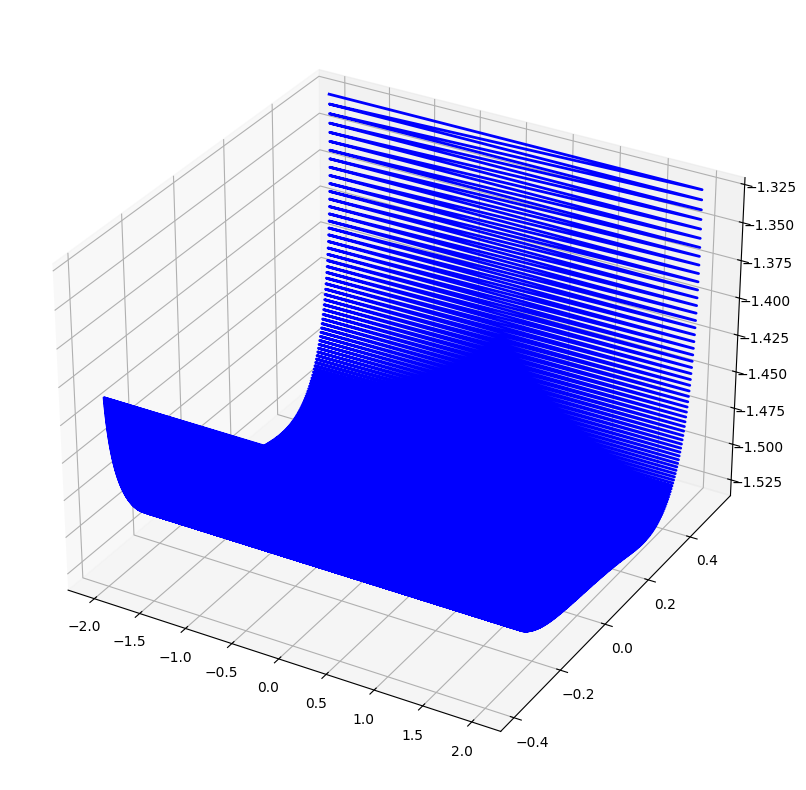

In [17]:
def plot_activation_functions_3d(model, layer, tuple1, tuple2, x_range=(-2, 2), n_points=40000):
    """
    Create a 3D plot showing the relationship between two activation functions.
    
    Args:
        model: MultKAN model
        layer: layer to evaluate
        tuple1: (i,j) tuple for first function
        tuple2: (i,j) tuple for second function
        x_range: tuple of (min_x, max_x)
        n_points: number of evaluation points
    """
    # Generate evaluation points
    x_eval = torch.linspace(x_range[0], x_range[1], n_points)
    
    # Get individual functions
    functions = get_individual_functions(model, layer, [tuple1, tuple2], x_eval)
    
    # Convert to numpy for plotting
    x = x_eval.numpy()
    y = functions[0].detach().numpy()
    z = functions[1].detach().numpy()
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot 3D curve
    ax.plot(x, y, z, 'b-', linewidth=2, label='Combined trajectory')
    
    # Add scattered points for better visibility
    scatter = ax.scatter(x, y, z, c=x, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='x value')
    
    # Labels and title
    ax.set_xlabel(f'x')
    ax.set_ylabel(f'φ{tuple1}')
    ax.set_zlabel(f'φ{tuple2}')
    ax.set_title(f'3D Visualization of Activation Functions\nLayer {layer}')
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True)
    
    return fig, ax

# Example usage:
fig, ax = plot_activation_functions_3d(
    model, 
    layer=0, 
    tuple1=(0,0),  # First activation function
    tuple2=(1,1),  # Second activation function
    x_range=(-2, 2),
    n_points=400
)
plt.show()

In [ ]:
# VMC to update wavefunction
# VMC using local energy and kfac
# Early stopping/a set number of steps

In [ ]:
# Take updated function, i.e. coeffs, and genearte new training labels for sampling points
# Add noise to training label data, level and sparsity of question.

In [ ]:
# Train network to learn new function representation
# iterate until convergence...